# DBSCAN

## Part 1: Data Processing

We will use the same Palmer Penguins dataset as before.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load & clean data (Palmer Penguins)
df = sns.load_dataset("penguins")
df = df.dropna(subset=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"])

I chose to use all four features to classify the pengiuns. Additionally, we will regularize the data so that it all exists on the same scale. This is important because we are defining a radius which must work in each feature's dimension.

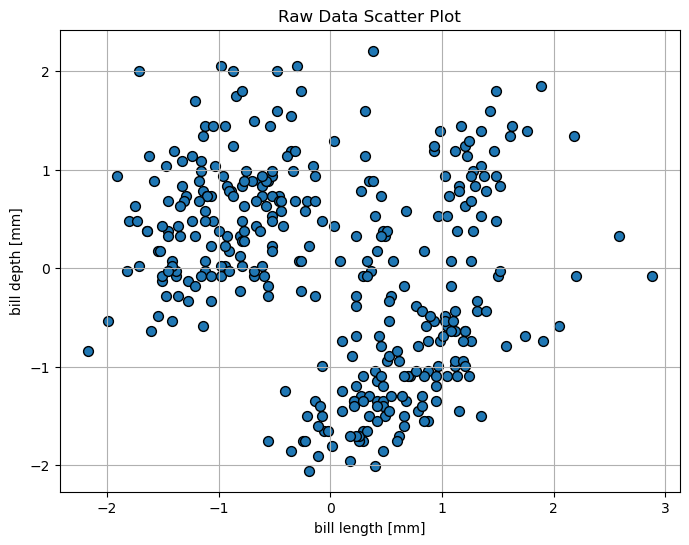

In [55]:
# Select features for clustering
X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values

# Standardize features (important for distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    s=50, edgecolor='k'
)
plt.xlabel("bill length [mm]")
plt.ylabel("bill depth [mm]")
plt.title("Raw Data Scatter Plot")
plt.grid(True)
plt.show()

## Part 2: The Model
Now we will use the `DBSCAN` method from sklearn. I chose to try radii of 0.5 and 0.65, and require 5 points and 4 points to be inside each respective radius in order for a point to be classifed as a core point. I also used the Euclidean distance measure as I found that to be the best in most of my previous models.

In [47]:
# eps = neighborhood radius (in scaled units)
# min_samples = min points to form a dense region
db_one = DBSCAN(eps=0.5, min_samples=5, metric="euclidean")
labels_one = db_one.fit_predict(X_scaled)  
#   labels = -1 denotes noise points

db_two = DBSCAN(eps=0.65, min_samples=4, metric="euclidean")
labels_two = db_two.fit_predict(X_scaled) 

# Attach cluster labels back to DataFrame
df["dbscan_cluster_one"] = labels_one
df["dbscan_cluster_two"] = labels_two
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,dbscan_cluster_one,dbscan_cluster_two
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,0
...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,3,2
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,3,2
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,3,2
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,3,2


---
## Part 3: Analysis

To measure our model's predictions, we will compute the silhouette score as follows for each data point, i: 
- a(i) = average distance from i to all other points in the same cluster
- b(i) = minimum over clusters C≠cluster(i) of (average distance from i to all points in C)

s(i) = (b(i) – a(i)) / max{a(i), b(i)}

Score interpretation:
- s(i) ≈ +1 ⇒ i is appropriately clustered (a(i) ≪ b(i))
- s(i) ≈ 0 ⇒ i lies on the border between two clusters
- (i) ≈ –1 ⇒ i may have been assigned to the wrong cluster

To find the overall score, compute s(i) for every point (ignoring, or specially handling, DBSCAN’s noise points labeled –1) and then take the mean:    
**Silhouette Score** = mean₍i₎ s(i)

In [53]:
# evaluate
n_clusters1 = len(set(labels_one)) - (1 if -1 in labels_one else 0)
n_noise1    = list(labels_one).count(-1)
print(f"Estimated clusters: {n_clusters1}")
print(f"Noise points: {n_noise1}")
if n_clusters1 > 1:
    sil_score1 = silhouette_score(X_scaled, labels_one)
    print(f"Silhouette Score (radius = 0.5, samples = 5): {sil_score1:.3f}\n")

n_clusters2 = len(set(labels_two)) - (1 if -1 in labels_two else 0)
n_noise2    = list(labels_two).count(-1)
print(f"Estimated clusters: {n_clusters2}")
print(f"Noise points: {n_noise2}")
if n_clusters2 > 1:
    sil_score2 = silhouette_score(X_scaled, labels_two)
    print(f"Silhouette Score (radius = 0.65, samples = 4): {sil_score2:.3f}")

Estimated clusters: 4
Noise points: 69
Silhouette Score (radius = 0.5, samples = 5): 0.250

Estimated clusters: 3
Noise points: 15
Silhouette Score (radius = 0.65, samples = 4): 0.380


Judging from the metrics above, tweaking the inputs even slightly results in a vastly different output. The second, "looser" model has many less noise points that the stricter model. The second model also earned a higher Silhouette Score, indicating that its clusters are more separable and well-formed. Also, it is important to note that the second model correctly predicted the number of species of penguins in our data. Now we will visualize this difference.

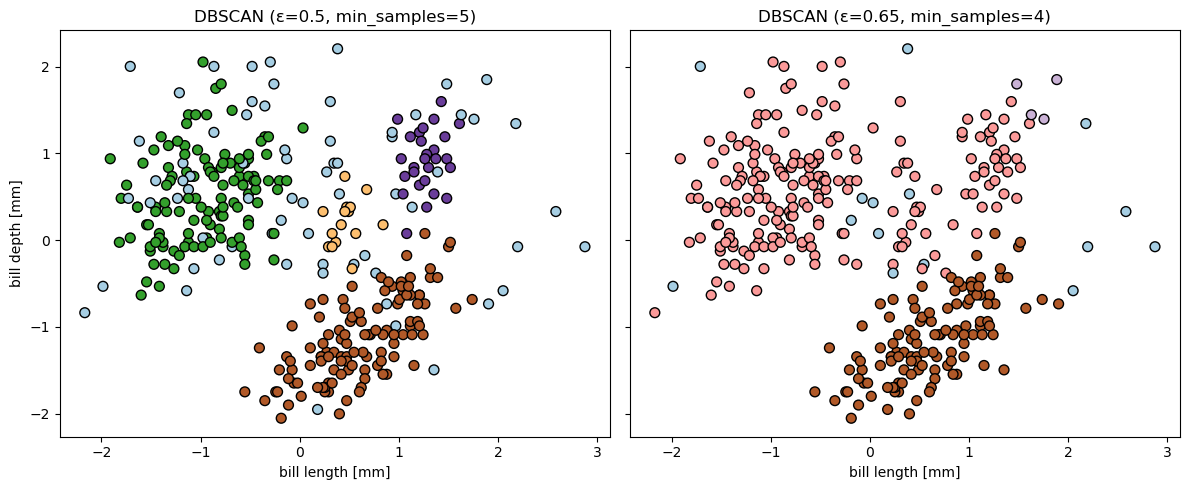

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# First clustering
ax1.scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=labels_one, cmap="Paired", s=50, edgecolor="k"
)
ax1.set_title("DBSCAN (ε=0.5, min_samples=5)")
ax1.set_xlabel("bill length [mm]")
ax1.set_ylabel("bill depth [mm]")

# Second clustering
ax2.scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=labels_two, cmap="Paired", s=50, edgecolor="k"
)
ax2.set_title("DBSCAN (ε=0.65, min_samples=4)")
ax2.set_xlabel("bill length [mm]")

plt.tight_layout()
plt.show()

### Conclusion
- This model shows the importance of visualizing the data. In the plots above, it becomes evident that the first model actually has more informative clusters than the second. In fact, in the second model, one of the clusterings hardly consists of any points at all, which is **not** in alignment with the dataset, where about a third of the samples come from each species. Despite the fact that the first model predicts 4 species instead of 3, its clusters are more discernible in the plot.